In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pickle as pk
%matplotlib inline

import keras
from keras.layers import Dense, Activation, Input, Dropout
from keras.models import Model

Using Theano backend.


In [2]:
f = open('./data.txt')
d = f.read()
f.close()

data = d[1260:]
data = data.lower().decode('utf-8')
import re

p = re.sub('[^A-Za-z]+', ' ', data)
ds = p.split()

In [3]:
bow = pk.load(open('./bow.pkl', 'rb'))
rev_bow = pk.load(open('./rev_bow.pkl', 'rb'))
vecs = np.load('./all_word_data.npy')

print len(bow.keys()), len(rev_bow.keys()), vecs.shape

1781 1781 (35456, 1781)


In [4]:
for ix in range(10):
    print bow[vecs[ix].argmax()]

it
is
often
enough
and
always
with
great
to
me


In [5]:
X = np.zeros((vecs.shape[0]-1, vecs.shape[1]*2))

for ix in range(X.shape[0]-1):
    X[ix] = np.hstack((vecs[ix], vecs[ix+1]))

In [6]:
y = vecs[1:]

print X.shape, y.shape

(35455, 3562) (35455, 1781)


In [7]:
split = int(0.85 * X.shape[0])

X_train = X[:split]
X_val = X[split:]
y_train = y[:split]
y_val = y[split:]

print X_train.shape, X_val.shape
print y_train.shape, y_val.shape

(30136, 3562) (5319, 3562)
(30136, 1781) (5319, 1781)


In [8]:
embedding = 50

inp = Input(shape=(3562,))
emb = Dense(embedding, activation='tanh')(inp)
emb = Dropout(0.32)(emb)
out = Dense(1781, activation='softmax')(emb)

model = Model(input=inp, output=out)
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
encoder = Model(input=inp, output=emb)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 3562)          0                                            
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 50)            178150      input_1[0][0]                    
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 50)            0           dense_1[0][0]                    
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 1781)          90831       dropout_1[0][0]                  
Total params: 268,981
Trainable params: 268,981
Non-trainable params: 0
___________________

In [9]:
hist = model.fit(X_train, y_train,
                nb_epoch=30,
                shuffle=True,
                batch_size=100,
                validation_data=(X_val, y_val), verbose=2)

Train on 30136 samples, validate on 5319 samples
Epoch 1/30
19s - loss: 5.9960 - acc: 0.2006 - val_loss: 5.3932 - val_acc: 0.2704
Epoch 2/30
18s - loss: 4.2080 - acc: 0.3595 - val_loss: 4.4200 - val_acc: 0.4330
Epoch 3/30
20s - loss: 3.2180 - acc: 0.5357 - val_loss: 3.7045 - val_acc: 0.5524
Epoch 4/30
20s - loss: 2.4842 - acc: 0.6655 - val_loss: 3.2442 - val_acc: 0.6114
Epoch 5/30
21s - loss: 1.9921 - acc: 0.7434 - val_loss: 2.9223 - val_acc: 0.6719
Epoch 6/30
20s - loss: 1.6442 - acc: 0.8052 - val_loss: 2.6809 - val_acc: 0.6999
Epoch 7/30
20s - loss: 1.3683 - acc: 0.8480 - val_loss: 2.4970 - val_acc: 0.7280
Epoch 8/30
17s - loss: 1.1491 - acc: 0.8791 - val_loss: 2.3660 - val_acc: 0.7447
Epoch 9/30
17s - loss: 0.9661 - acc: 0.9023 - val_loss: 2.2702 - val_acc: 0.7554
Epoch 10/30
18s - loss: 0.8152 - acc: 0.9191 - val_loss: 2.1892 - val_acc: 0.7680
Epoch 11/30
19s - loss: 0.6921 - acc: 0.9340 - val_loss: 2.1209 - val_acc: 0.7753
Epoch 12/30
18s - loss: 0.5827 - acc: 0.9466 - val_loss: 2

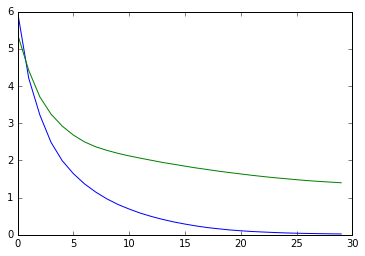

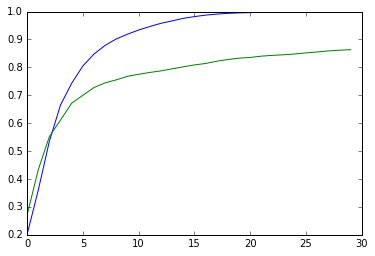

In [10]:
th = hist.history

plt.figure(0)
plt.plot(th['loss'], 'b')
plt.plot(th['val_loss'], 'g')

plt.figure(1)
plt.plot(th['acc'], 'b')
plt.plot(th['val_acc'], 'g')

In [11]:
a = encoder.predict(X)
# print a[0]

In [12]:
w2v = {}
alpha = 0.8
for ix in range(X.shape[0]):
    try:
        old_vec = w2v[bow[y[ix].argmax()]]
        new_vec = alpha*old_vec + (1-alpha)*a[ix]
        w2v[bow[y[ix].argmax()]] = new_vec
    except:
        w2v[bow[y[ix].argmax()]] = a[ix]
print len(w2v.keys())

1781


In [13]:
def similarity(a1, a2):
    return np.dot(a1, a2)/np.sqrt((a1**2).sum()*(a2**2).sum())

In [14]:
v1 = w2v['it']
v2 = w2v['this']
print similarity(v1, v2)

0.180764
